In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0, "../0.data-download/scripts/")
from data_loader import load_data, load_train_test_data

In [2]:
# data path
data_directory = "../0.data-download/data/"

In [3]:
# load the training data
dfs_test, dfs, data = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=False
)

In [4]:
# set a unique dataframe that can be appended from
training_df_age = dfs

# group by age and create new dataframes that can be appended to
groups = training_df_age.groupby("age_and_sex")
adult_dependency_df = pd.DataFrame()
ped_dependency_df = pd.DataFrame()
for name, training_df_age in groups:

    # append rows that contain Adult samples (male or female) to the new adult dependency dataframe
    if name == "Adult_Male" or name == "Adult_Female" or name == "Adult_nan":
        adult_dependency_df = adult_dependency_df.append(training_df_age)
        adult_dependency_df = adult_dependency_df.reset_index(drop=True)

    # append rows that contain Pediatric samples (male ore female) to the new pediatric dataframe
    else:
        ped_dependency_df = ped_dependency_df.append(training_df_age)
        ped_dependency_df = ped_dependency_df.reset_index(drop=True)

In [5]:
# set a unique dataframe that can be appended from
training_df_sex = dfs

# group by sex and create new dataframes to be appended to
groups_sex = training_df_sex.groupby("age_and_sex")
male_dependency_df = pd.DataFrame()
female_dependency_df = pd.DataFrame()
for name, training_df_sex in groups_sex:

    # append rows that contain Male samples (Adult or Pediatric) to the new male dependency dataframe and filter out samples that contain no gender info
    if (
        name == "Adult_Male"
        or name == "Pediatric_Male"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        male_dependency_df = male_dependency_df.append(training_df_sex)
        male_dependency_df = male_dependency_df.reset_index(drop=True)

    # append rows that contain Female samples (Adult or Pediatric) to the new female dependency dataframe and filter out samples that contain no gender info
    elif (
        name == "Adult_Female"
        or name == "Pediatric_Female"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        female_dependency_df = female_dependency_df.append(training_df_sex)
        female_dependency_df = female_dependency_df.reset_index(drop=True)

In [6]:
print(adult_dependency_df.shape)
adult_dependency_df.head(3)

(117, 16710)


,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-002119,0.054300,0.072419,0.077664,0.023551,0.113294,0.145097,0.008367,0.442225,0.046417,...,0.345949,0.612644,0.514132,0.032483,0.056335,0.109993,0.018293,0.079695,0.438080,Adult_Female
1,ACH-000581,0.056417,0.121627,0.057427,0.000674,0.054804,0.007661,0.005010,0.052158,0.089491,...,0.069678,0.037535,0.301469,0.040697,0.010493,0.016145,0.179888,0.206695,0.155791,Adult_Female
2,ACH-000667,0.005075,0.053123,0.014117,0.008119,0.044222,0.028080,0.005962,0.079255,0.024002,...,0.027429,0.169804,0.829728,0.036113,0.044269,0.042074,0.159061,0.103162,0.784805,Adult_Female


In [7]:
print(ped_dependency_df.shape)
ped_dependency_df.head(3)

(16, 16710)


,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-002282,0.101843,0.009030,0.013444,0.006819,0.033310,0.023551,0.032996,0.854005,0.014515,...,0.531982,0.185015,0.565117,0.041774,0.021044,0.106647,0.024238,0.109707,0.319439,Pediatric_Female
1,ACH-001188,0.029574,0.061570,0.020893,0.010941,0.047840,0.011876,0.018788,0.380459,0.024553,...,0.555168,0.065964,0.121725,0.043851,0.020272,0.121584,0.047323,0.183559,0.265632,Pediatric_Female
2,ACH-001031,0.119068,0.163991,0.012792,0.038770,0.164667,0.020185,0.049726,0.410744,0.090828,...,0.689039,0.242868,0.244553,0.022116,0.044204,0.498313,0.152466,0.356784,0.179180,Pediatric_Female


In [8]:
print(male_dependency_df.shape)
male_dependency_df.head(3)

(75, 16710)


,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000433,0.100560,0.018225,0.007916,0.045209,0.057526,0.008058,0.081892,0.233896,0.080371,...,0.067879,0.058411,0.665490,0.004632,0.097983,0.014455,0.103713,0.050344,0.059560,Adult_Male
1,ACH-002263,0.085741,0.011221,0.061335,0.018384,0.173255,0.083615,0.041639,0.117463,0.038275,...,0.376772,0.332010,0.923912,0.030266,0.081819,0.098370,0.111234,0.050567,0.303664,Adult_Male
2,ACH-000765,0.014727,0.017028,0.018528,0.013820,0.021784,0.046196,0.022473,0.185780,0.081312,...,0.278382,0.015317,0.166557,0.020221,0.059067,0.120977,0.012982,0.004535,0.386779,Adult_Male


In [9]:
print(female_dependency_df.shape)
female_dependency_df.head(3)

(58, 16710)


,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-002119,0.054300,0.072419,0.077664,0.023551,0.113294,0.145097,0.008367,0.442225,0.046417,...,0.345949,0.612644,0.514132,0.032483,0.056335,0.109993,0.018293,0.079695,0.438080,Adult_Female
1,ACH-000581,0.056417,0.121627,0.057427,0.000674,0.054804,0.007661,0.005010,0.052158,0.089491,...,0.069678,0.037535,0.301469,0.040697,0.010493,0.016145,0.179888,0.206695,0.155791,Adult_Female
2,ACH-000667,0.005075,0.053123,0.014117,0.008119,0.044222,0.028080,0.005962,0.079255,0.024002,...,0.027429,0.169804,0.829728,0.036113,0.044269,0.042074,0.159061,0.103162,0.784805,Adult_Female


In [10]:
# drop the string values from all dataframes
adult_dependency_df_float = adult_dependency_df.drop(
    columns=["DepMap_ID", "age_and_sex"]
)
ped_dependency_df_float = ped_dependency_df.drop(columns=["DepMap_ID", "age_and_sex"])

male_dependency_df_float = male_dependency_df.drop(columns=["DepMap_ID", "age_and_sex"])
female_dependency_df_float = female_dependency_df.drop(
    columns=["DepMap_ID", "age_and_sex"]
)

dependency_df = dfs.drop(columns="age_and_sex")
dependency_df = dependency_df.set_index("DepMap_ID")

In [11]:
# t_test comparing gene dependencies in adult vs pediatric samples
t_test = ttest_ind(adult_dependency_df_float, ped_dependency_df_float)
t_test = pd.DataFrame(t_test).T
t_test.columns = ["t_stat", "p_value"]
print(t_test.shape)
t_test.head(3)

(16708, 2)


,t_stat,p_value
0,0.219771,0.826391
1,1.244988,0.215359
2,0.953707,0.341988


In [12]:
# t_test comparing gene dependencies in male vs female samples
t_test_sex = ttest_ind(male_dependency_df_float, female_dependency_df_float)
t_test_sex = pd.DataFrame(t_test_sex).T
t_test_sex.columns = ["t_stat", "p_value"]
print(t_test_sex.shape)
t_test_sex.head(3)

(16708, 2)


,t_stat,p_value
0,-1.096926,0.274686
1,-0.592586,0.554480
2,-1.016203,0.311406


In [13]:
print(dependency_df.shape)
dependency_df.head(3)

(133, 16708)


,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZUP1 (221302),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000433,0.100560,0.018225,0.007916,0.045209,0.057526,0.008058,0.081892,0.233896,0.080371,0.009400,...,0.087090,0.067879,0.058411,0.665490,0.004632,0.097983,0.014455,0.103713,0.050344,0.059560
ACH-002263,0.085741,0.011221,0.061335,0.018384,0.173255,0.083615,0.041639,0.117463,0.038275,0.019785,...,0.035695,0.376772,0.332010,0.923912,0.030266,0.081819,0.098370,0.111234,0.050567,0.303664
ACH-002119,0.054300,0.072419,0.077664,0.023551,0.113294,0.145097,0.008367,0.442225,0.046417,0.010340,...,0.069288,0.345949,0.612644,0.514132,0.032483,0.056335,0.109993,0.018293,0.079695,0.438080


In [14]:
# calculate variance of each gene then send the results plus the gene info into a new dataframe
variance = dependency_df.var()
variance_list = variance.tolist()
column_names = ["variance"]
variance_df = pd.DataFrame(variance, columns=column_names)
variance_df = variance_df.sort_index(ascending=True).reset_index()
variance_df = variance_df.rename(columns={"index": "gene_ID"})
print(variance_df.shape)
variance_df.head(3)

(16708, 2)


,gene_ID,variance
0,A1BG (1),0.004270
1,A1CF (29974),0.004584
2,A2M (2),0.000382


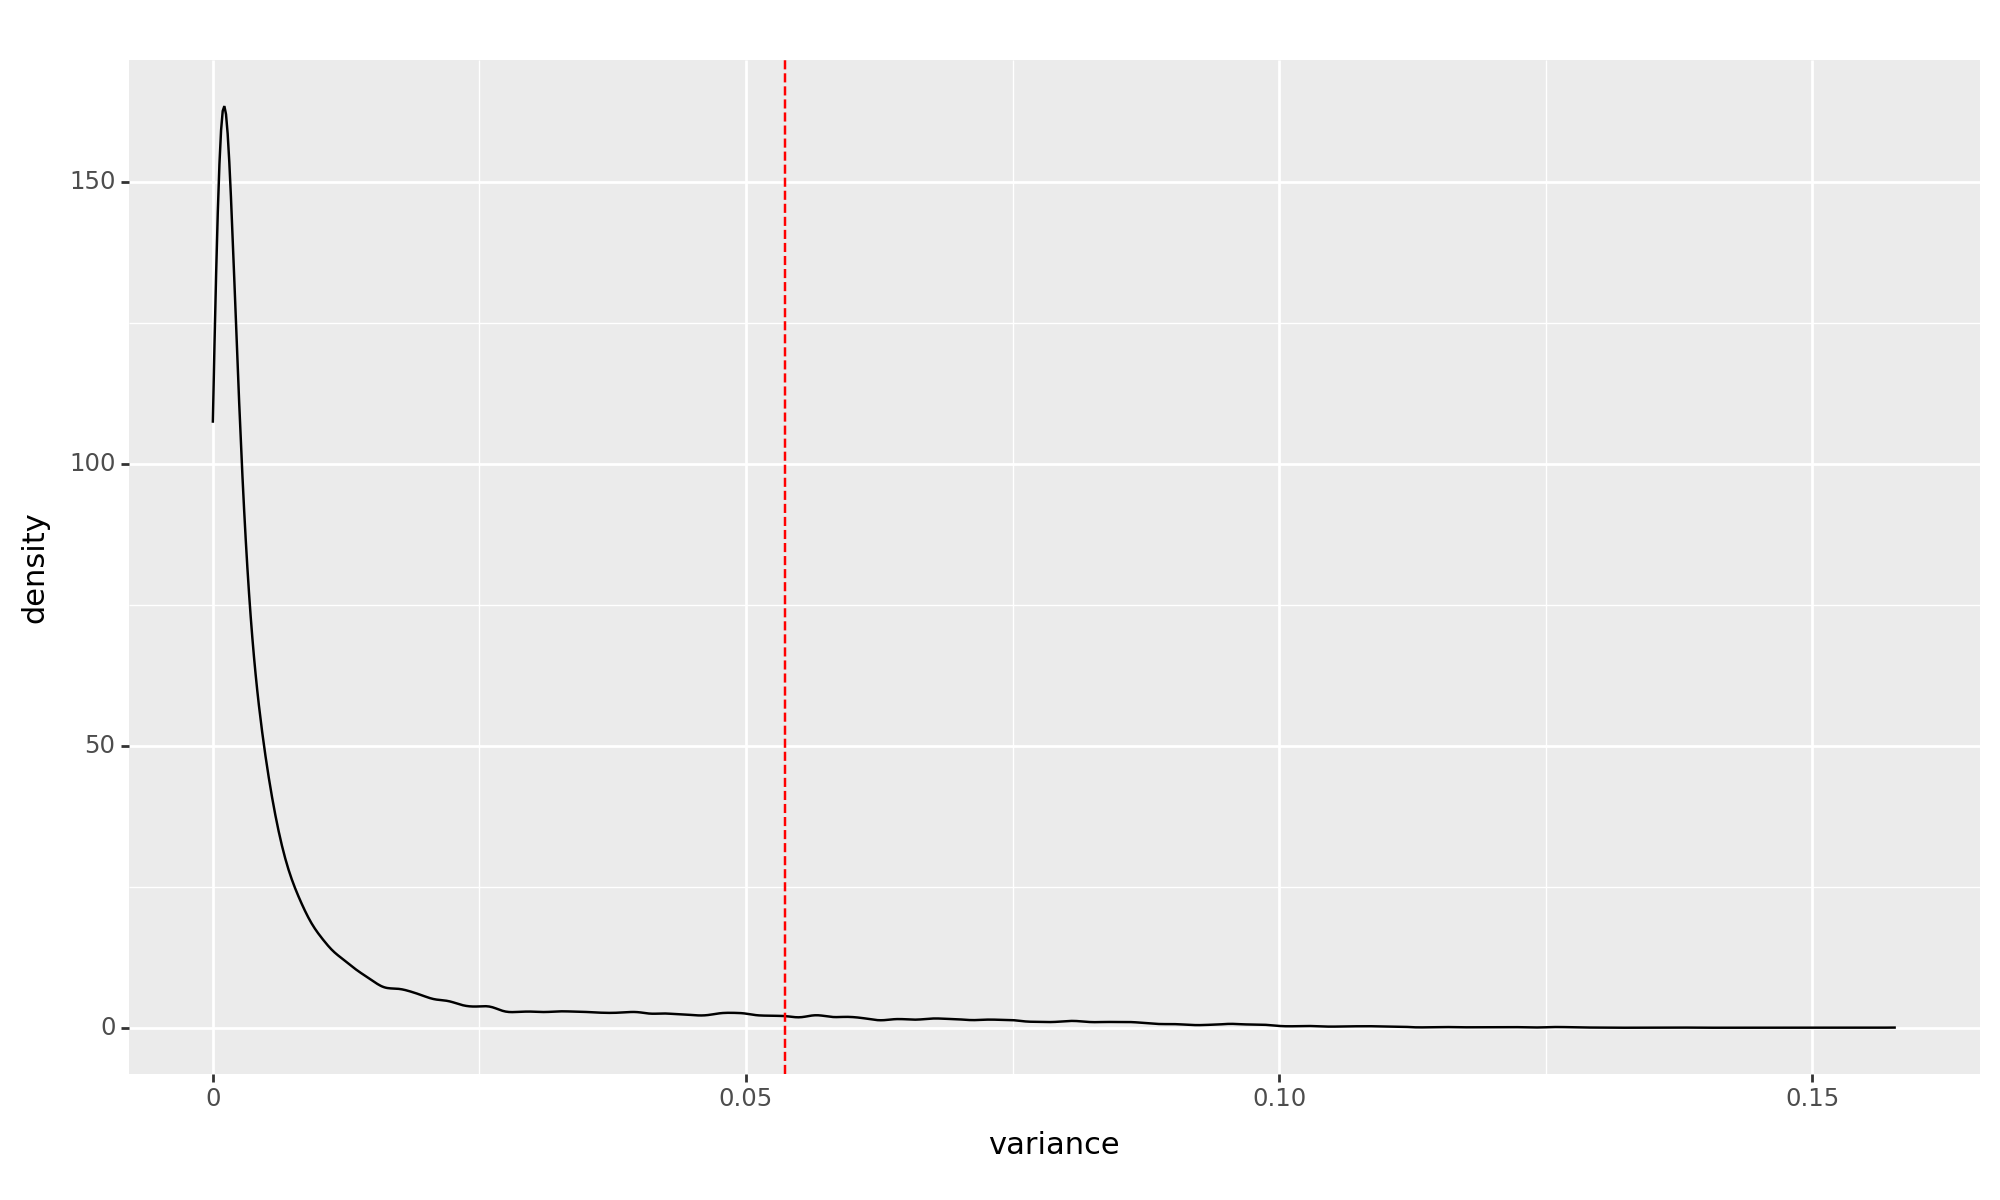

<Figure Size: (1000 x 600)>

In [15]:
# finding the smallest gene variation out of the 1000 largest gene variations to set the top 1000 gene variances threshold
n = variance_df["variance"].nlargest(1000)
variance_theshold = n.astype(float).min()

# plotting variance density chart and marking the 1000 largest gene variation cutoff
variance_density_plot = (
    p9.ggplot(variance_df, p9.aes(x="variance"))
    + p9.geom_density()
    + p9.geom_vline(xintercept=variance_theshold, linetype="dashed", color="red")
    + p9.theme(figure_size=(10, 6))
)

# save the figure
density_path = pathlib.Path("./figures/variance_density_plot.png")
variance_density_plot.save(density_path)
variance_density_plot

In [16]:
# first create new dataframe containing gene info as well as both adult-pediatric and male-female t-test results and variance results
df = variance_df.assign(
    ttest_A_vs_P=t_test.t_stat.astype(float),
    ttest_M_vs_F=t_test_sex.t_stat.astype(float),
)

# and save the new dataframe as a .csv
testing_df_output = pathlib.Path(
    "../0.data-download/data/genes_variances_and_t-tests_df.csv"
)
df.to_csv(testing_df_output, index=False)
print(df.shape)
df.head(3)

(16708, 4)


,gene_ID,variance,ttest_A_vs_P,ttest_M_vs_F
0,A1BG (1),0.004270,0.219771,-1.096926
1,A1CF (29974),0.004584,1.244988,-0.592586
2,A2M (2),0.000382,0.953707,-1.016203


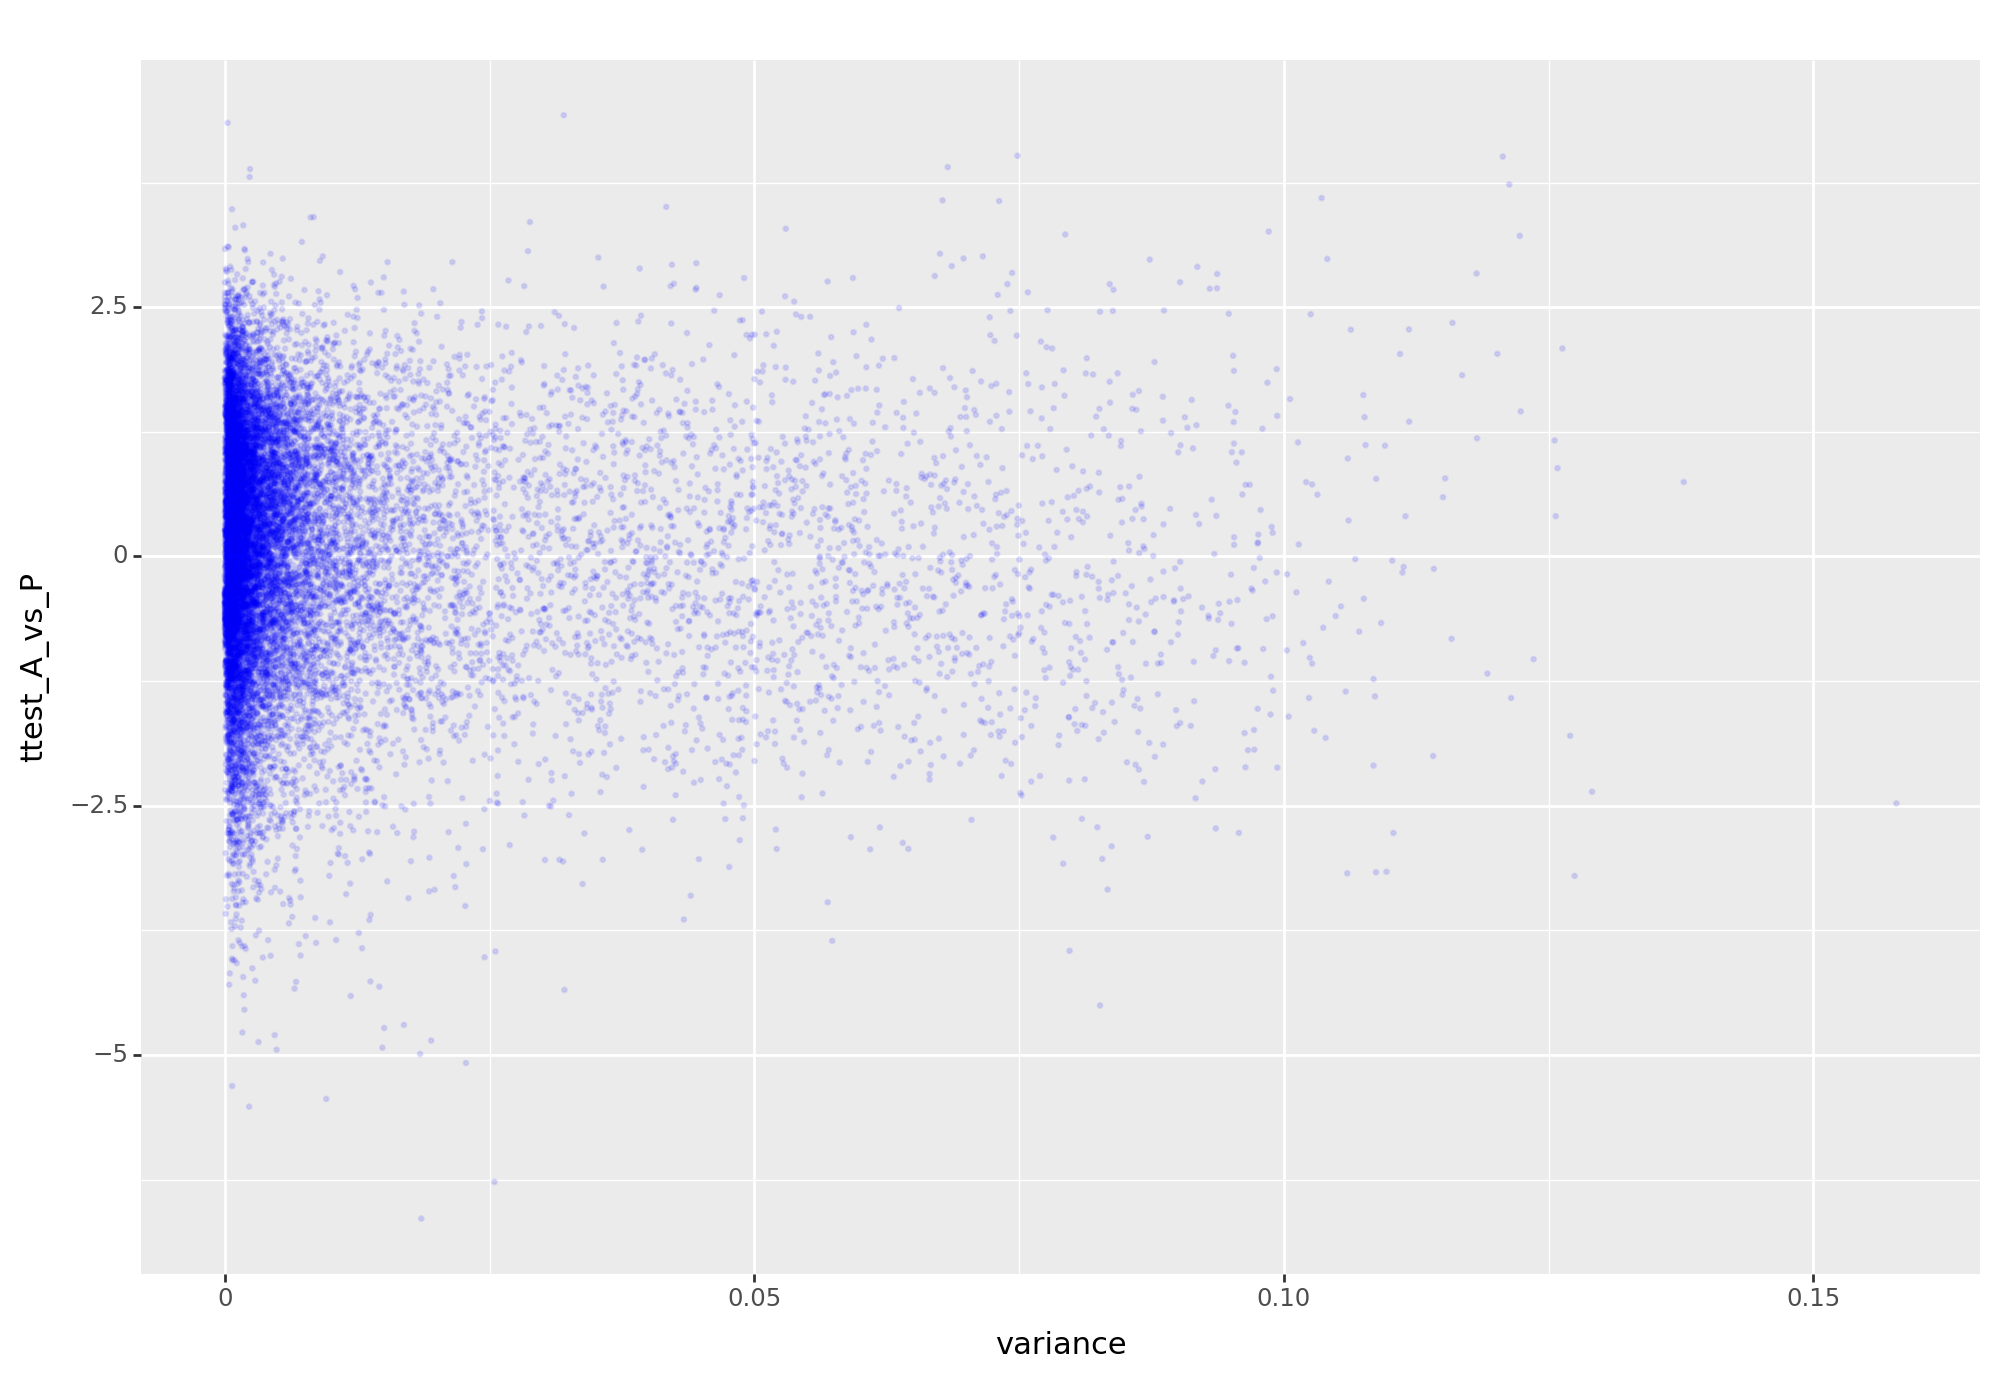

<Figure Size: (1000 x 700)>

In [17]:
# plot adult-pediatric ttest versus variance
A_vs_P_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_A_vs_P"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
adult_vs_pediatric_path = pathlib.Path(
    "./figures/adult-pediatric_ttest_vs_variance.png"
)
A_vs_P_by_variance_plot.save(adult_vs_pediatric_path)
A_vs_P_by_variance_plot

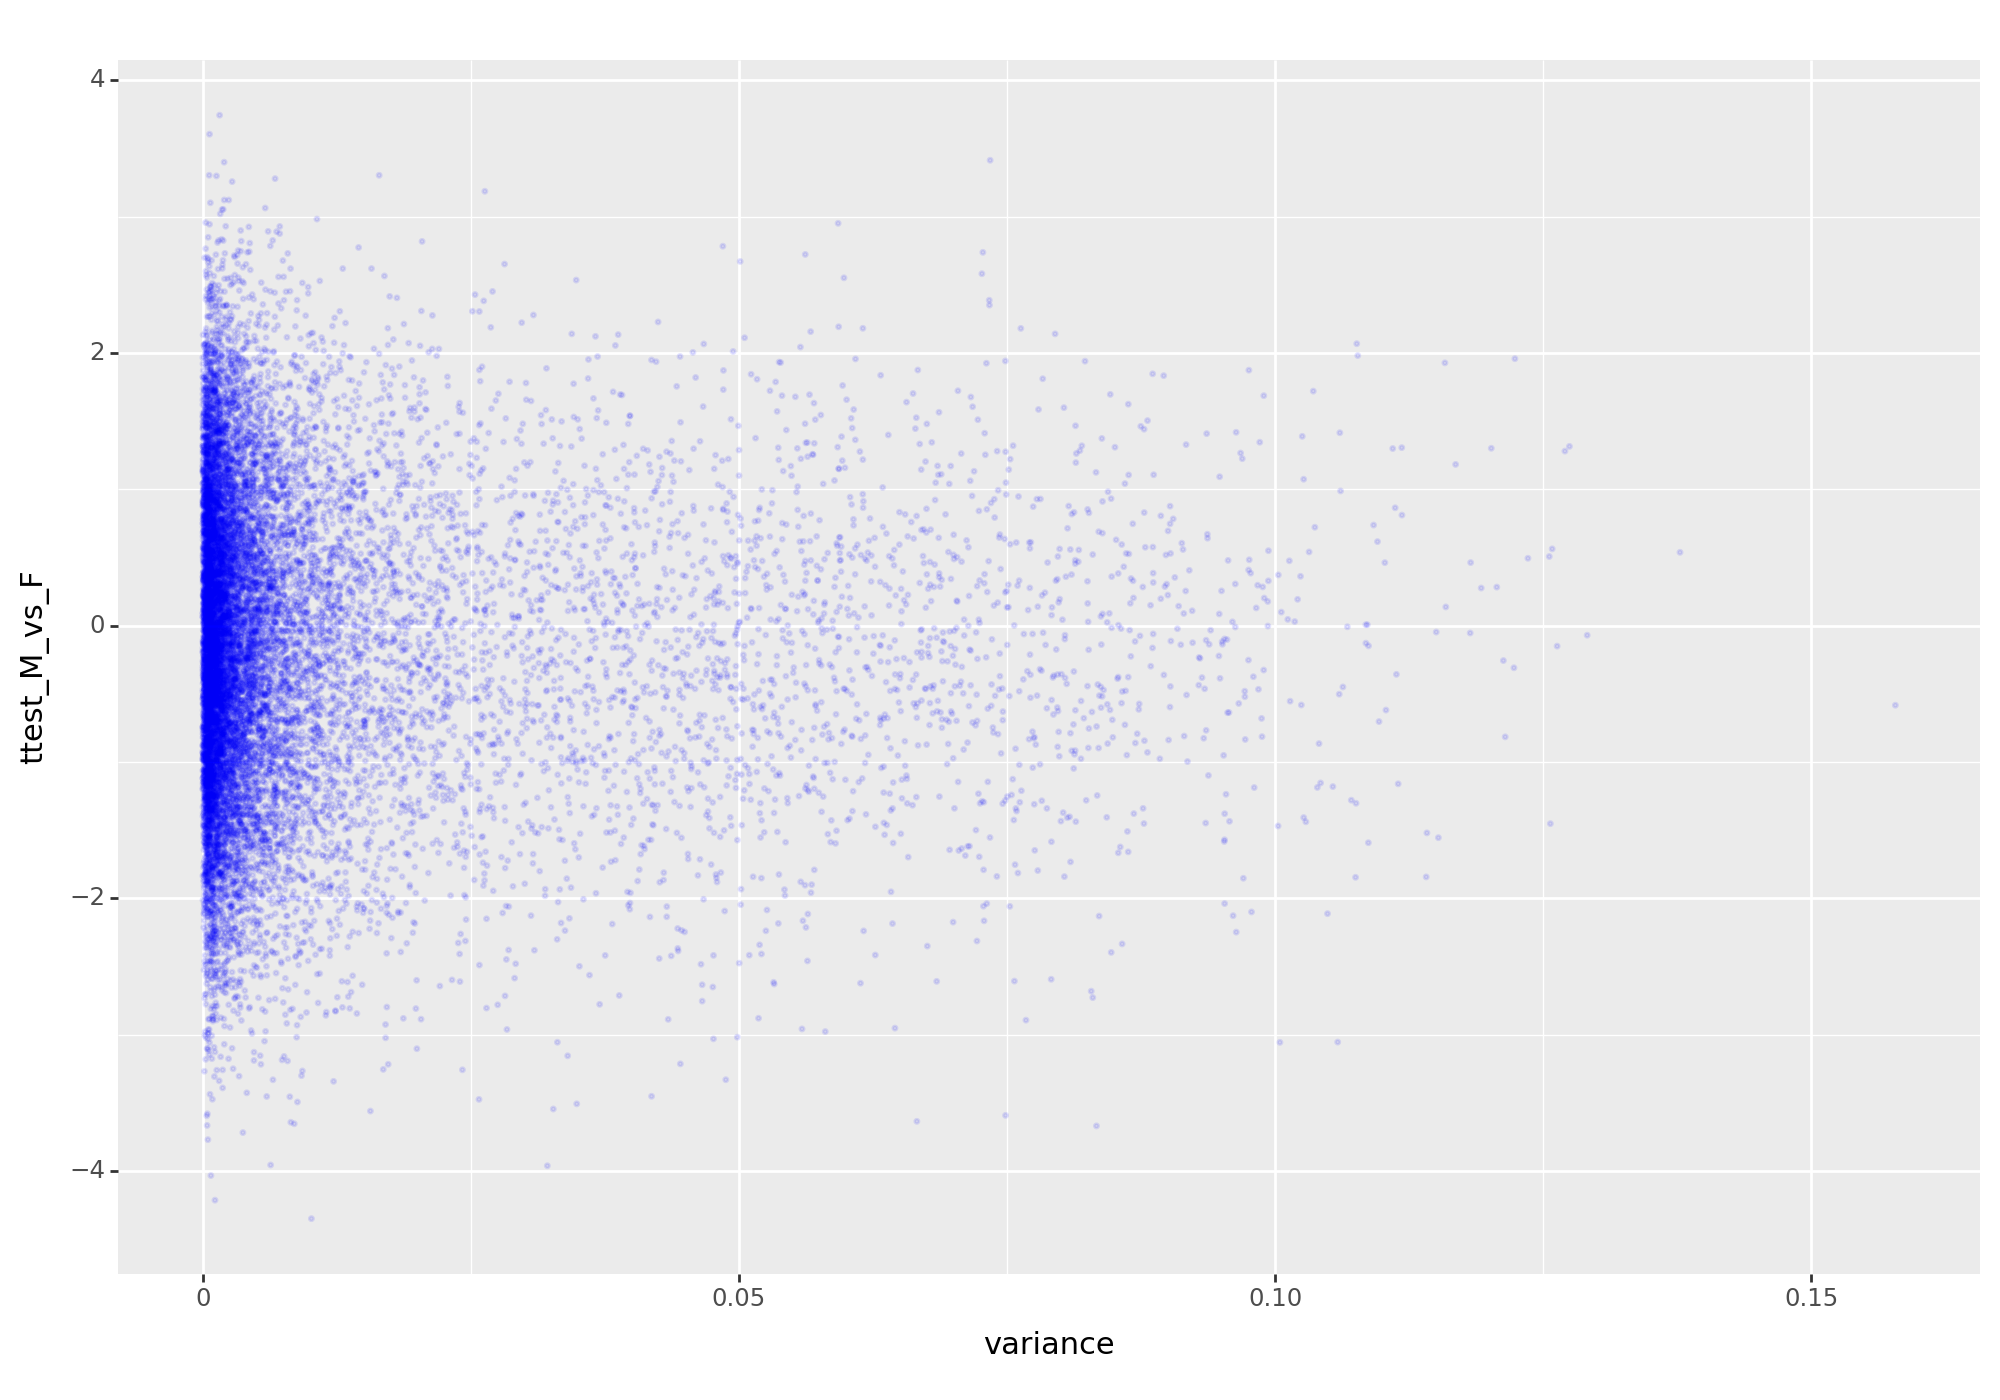

<Figure Size: (1000 x 700)>

In [18]:
# plot male-female ttest versus gene variance
M_vs_F_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_M_vs_F"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
male_vs_female_path = pathlib.Path("./figures/male-female_ttest_vs_variance.png")
M_vs_F_by_variance_plot.save(male_vs_female_path)
M_vs_F_by_variance_plot